In [1]:
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import pickle
from struct import *
import pandas as pd
import seaborn as sns
import mixture
sns.set_style("white")
import warnings
warnings.filterwarnings("ignore")
import collections
from math import pi, cos, sin, cosh, tanh
from scipy.spatial.transform import Rotation as Rot
import cv2
import plotting
from plotting import *
import scipy.interpolate
import scipy.integrate
import scipy.stats
from sklearn.linear_model import RANSACRegressor, TheilSenRegressor, LinearRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
from scipy.signal import argrelextrema
from statistics import median
from scipy.stats import pearsonr

In [2]:
#
# Define colors and states for plotting events.
#
STATES = ['fix', 'sac', 'smp', 'vor', 'blink', 'fix_blink', 'sac_blink', 'other', 'loss']
COLORS = {'fix':'red', 'sac':'lime', 'smp':'purple', 'vor':'brown', 'blink':'dodgerblue', 'fix_blink':'darkorchid', 'sac_blink':'turquoise', 'other':'grey', 'loss':'gold'}
BORDERS = {'fix':'magenta', 'sac':'green', 'smp':'blue', 'vor':'tan', 'blink':'royalblue', 'fix_blink':'darkviolet', 'sac_blink':'lightseagreen', 'other':'black', 'loss':'yellow'}
BINS = 50

## Load data

In [3]:
seq = pd.read_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv', index_col=[0])
seq = seq.loc[:,'HMD':]

In [4]:
nn = pd.read_csv('/data/Isabella/thesis_spring2022/NN/results_after_FI.csv', index_col=[0])

In [5]:
# Upload the error data
#errors = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/tagged_errors.csv', index_col=[0])
errors_ = pd.read_csv('/home/s202576/thesis_spring2022/NN/data_prep/error-tags_full.csv', index_col=[0])

errors_.loc[:, 'subID':'Track'] = errors_.loc[:, 'subID':'Track'].astype(str)
#errors.loc[:, 'Timestamp':'value5b'] = errors.loc[:, 'Timestamp':'value5b'].astype(float)
errors_.loc[:, 'HMD'] = errors_.loc[:, 'HMD'].astype(str)
errors_.loc[:, 'offset'] = errors_.loc[:, 'offset'].astype(bool)
#errors.loc[:, 'Timestamp_adjusted'] = errors.loc[:, 'Timestamp_adjusted'].astype(float)

# Determine whether the type of error is a motor error (and not a process error)
errors_['motor_error'] = False
for idx, row in errors_.iterrows():
    if row.error_type_value1=='1' or row.error_type_value2=='1' or row.error_type_value3=='1' or row.error_type_value4=='1' or row.error_type_value5=='1':
        errors_.loc[idx, 'motor_error'] = True
    
errors = errors_[errors_.motor_error==True]

errors.reset_index(drop=True, inplace=True)

assert all(errors['offset'] == True), "The timestamps of tagged errors have not been adjusted."

In [6]:
# # Use this to create unique identifier 'UID' in the data if it doesn't already exist
# if 'UID' not in seq.columns.tolist():
#     seq['UID'] = ''
#     for idx, row in seq.iterrows():
#         seq.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye
        
# if 'UID' not in seq_50.columns.tolist():
#     seq_50['UID'] = ''
#     for idx, row in seq_50.iterrows():
#         seq_50.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye
        
# if 'UID' not in seq_51.columns.tolist():
#     seq_51['UID'] = ''
#     for idx, row in seq_51.iterrows():
#         seq_51.loc[idx, 'UID'] = row.HMD+row.subID+row.task+row.eye

# del seq['Unnamed: 0.1']
# del seq_50['Unnamed: 0.1']
# del seq_51['Unnamed: 0.1']

# seq.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/all_sequences_varjo.csv')
# seq_50.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/50/all_sequences_50_varjo.csv')
# seq_51.to_csv('/data/Isabella/thesis_spring2022/event_detect_out_final/51/all_sequences_51_varjo.csv')

# # seq.head()

In [7]:
seq.head()

,HMD,rate,eye,task,subID,VL,event,start_i,end_i,start_s,...,calculus_error,carpenter_error,P_nonfix,P_fix,P_ff,P_smp,P_sac,P_blink,has_blink,UID
0,varjo,200,right,cereal,P19,CVL,smp,0,25,1.081565,...,0.366132,1.527210,0.534494,0.465506,5.470863e-11,0.465506,0.384207,0.150287,0,varjoP19cerealright
1,varjo,200,right,cereal,P19,CVL,fix,26,49,1.211610,...,0.230767,2.684010,0.059622,0.940378,8.531830e-01,0.087195,0.057516,0.002106,0,varjoP19cerealright
2,varjo,200,right,cereal,P19,CVL,sac,50,56,1.326648,...,0.732365,0.474248,0.728794,0.271206,2.022088e-01,0.068997,0.000396,0.728398,0,varjoP19cerealright
3,varjo,200,right,cereal,P19,CVL,noise,57,59,1.361658,...,NaN,NaN,0.667140,0.332860,3.218246e-01,0.011035,0.000000,0.000000,0,varjoP19cerealright
4,varjo,200,right,cereal,P19,CVL,fix,60,205,1.381670,...,0.913183,24.923594,NaN,NaN,NaN,NaN,NaN,NaN,0,varjoP19cerealright


In [8]:
nn

,subID,task,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs
0,P19,combined,6.201509,0.597313,0.688820,0.626667,0.687500,0.557143,0.962905,0.947082
0,P24,combined,6.062364,0.569662,0.729490,0.692105,0.500000,0.799180,0.926523,0.945131
0,P6,combined,6.704932,0.559025,0.736023,0.625000,0.436090,0.795918,0.921458,0.966606
0,P5,combined,8.287311,0.527193,0.784555,0.744444,0.904412,0.250000,0.979514,0.982248
0,P21,combined,8.479499,0.357770,0.953349,0.750000,0.724138,0.774194,0.997330,0.965248
0,P9,combined,7.457047,0.550240,0.752866,0.577273,0.531532,0.623853,0.970370,0.976538
0,P14,combined,7.237658,0.557704,0.750350,0.706250,0.868132,0.492754,0.986845,0.992951
0,P15,combined,7.027839,0.406700,0.905965,0.833333,0.956522,0.428571,0.998557,0.985639
0,P13,combined,6.855649,0.576228,0.729474,0.673333,0.896552,0.206186,0.980518,0.918382
0,P18,combined,7.451448,0.542691,0.758664,0.672727,0.790210,0.454545,0.962190,0.921216


In [9]:
errs = errors.groupby(['subID','task']).count()

In [10]:
errs = errs.loc[:,'motor_error']

In [11]:
task_errs = errors.groupby(['subID','task']).count()
task_errs = task_errs.loc[:,'motor_error']
num_errs = errors.groupby(['subID']).count()
num_errs = num_errs.loc[:,'motor_error']

nn = nn.set_index('subID')
nn = pd.concat([nn, num_errs], axis=1)
nn = nn.dropna()

In [12]:
# All participants and their respective vision loss
VL_map = {'P2':'CVL', 'P3':'CVL', 'P4':'Other', 'P5':'PVL', 'P6':'CVL', 'P8':'CVL', 'P9':'CVL', 'P10':'CVL',
                'P11':'PVL', 'P12':'PVL', 'P13':'CVL', 'P14':'PVL', 'P15':'PVL', 'P16':'PVL', 'P17':'PVL',
                'P18':'CVL', 'P19':'CVL', 'P21':'CVL', 'P22':'PVL', 'P23':'PVL', 'P24':'PVL', 'P25':'CVL'}

In [13]:
nn['VL'] = [VL_map[subID] for subID in nn.index]

In [14]:
nn

,task,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs,motor_error,VL
subID,,,,,,,,,,,
P19,combined,6.201509,0.597313,0.688820,0.626667,0.687500,0.557143,0.962905,0.947082,36,CVL
P24,combined,6.062364,0.569662,0.729490,0.692105,0.500000,0.799180,0.926523,0.945131,28,PVL
P6,combined,6.704932,0.559025,0.736023,0.625000,0.436090,0.795918,0.921458,0.966606,30,CVL
P5,combined,8.287311,0.527193,0.784555,0.744444,0.904412,0.250000,0.979514,0.982248,53,PVL
P21,combined,8.479499,0.357770,0.953349,0.750000,0.724138,0.774194,0.997330,0.965248,36,CVL
P9,combined,7.457047,0.550240,0.752866,0.577273,0.531532,0.623853,0.970370,0.976538,23,CVL
P14,combined,7.237658,0.557704,0.750350,0.706250,0.868132,0.492754,0.986845,0.992951,53,PVL
P15,combined,7.027839,0.406700,0.905965,0.833333,0.956522,0.428571,0.998557,0.985639,13,PVL
P13,combined,6.855649,0.576228,0.729474,0.673333,0.896552,0.206186,0.980518,0.918382,61,CVL


## Find outliers (noisy datasets)

In [15]:
# get the length of all datasets and calculate ratio of consecutive events
len_datasets = {}
dur_totals = {}
ratio_noise_loss_num = {}
ratio_blinks_num = {}
ratio_noise_loss_dur = {}
ratio_blinks_dur = {}
for HMD in seq.HMD.unique():
    for subID in seq.subID.unique():
        for task in seq.task.unique():
            for eye in seq.eye.unique():
                ID = HMD+subID+task+eye
                temp = seq.loc[(seq.HMD==HMD)&(seq.subID==subID)&(seq.task==task)&(seq.eye==eye)]
                if len(temp) != 0:
                    len_datasets[ID] = len(temp)
                    dur_totals[ID] = sum(temp.duration)
                    ratio_noise_loss_num[ID] = len(temp.loc[(temp.event=='noise') | (temp.event=='loss')])/len(temp)
                    ratio_blinks_num[ID] = len(temp.loc[(temp.event=='blink') | (temp.has_blink==True)])/len(temp)
                    ratio_noise_loss_dur[ID] = sum(temp.loc[(temp.event=='noise') | (temp.event=='loss'), 'duration'])/sum(temp.duration)
                    ratio_blinks_dur[ID] = sum(temp.loc[(temp.event=='blink') | (temp.has_blink==True),'duration'])/sum(temp.duration)


In [16]:
[k for k, v in ratio_noise_loss_num.items() if v == min(ratio_noise_loss_num.values())]

['varjoP3cerealright']

In [17]:
[k for k, v in ratio_noise_loss_dur.items() if v == min(ratio_noise_loss_dur.values())]

['varjoP25sandwichleft']

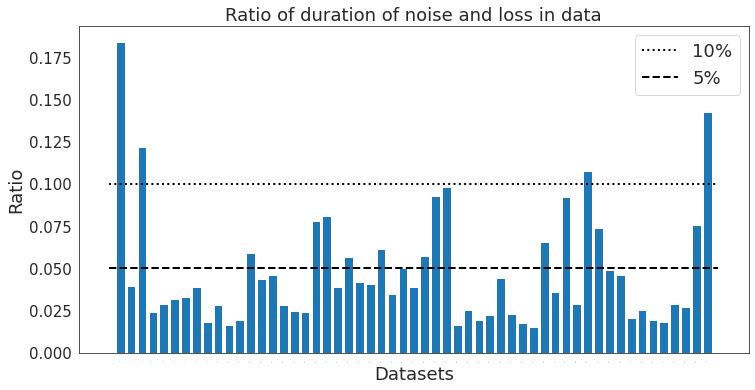

In [18]:
analyze_datasets(ratio_noise_loss_dur, title='Ratio of duration of noise and loss in data')

In [19]:
# # remove datasets where noise and loss account for more than 5% of dataset duration
# high_noise = [k for k,v in ratio_noise_loss_dur.items() if v > 0.10]

# n = len(seq.UID.unique())
# to_drop = []
# for idx, row in seq.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq = seq.drop(to_drop)
# seq.reset_index(inplace=True)

# to_drop = []
# for idx, row in seq_50.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq_50 = seq_50.drop(to_drop)
# seq_50.reset_index(inplace=True)

# to_drop = []
# for idx, row in seq_51.iterrows():
#     if row.UID in high_noise:
#         to_drop.append(idx)
# seq_51 = seq_51.drop(to_drop)
# seq_51.reset_index(inplace=True)

# print(f'dropped {len(high_noise)} datasets out of {n} ({np.round(len(high_noise)/n,2)*100}%)\n{high_noise}')

In [21]:
# get the length of all datasets in order to calculate ratio of consecutive events
len_datasets = {}
dur_totals = {}
ratio_noise_loss_num = {}
ratio_blinks_num = {}
ratio_noise_loss_dur = {}
ratio_blinks_dur = {}
for HMD in seq.HMD.unique():
    for subID in seq.subID.unique():
        for task in seq.task.unique():
            for eye in seq.eye.unique():
                ID = HMD+subID+task+eye
                temp = seq.loc[(seq.HMD==HMD)&(seq.subID==subID)&(seq.task==task)&(seq.eye==eye)]
                ID = subID
                if len(temp) != 0:
                    len_datasets[ID] = len(temp)
                    dur_totals[ID] = sum(temp.duration)
                    ratio_noise_loss_num[ID] = len(temp.loc[(temp.event=='noise') | (temp.event=='loss')])/len(temp)
                    ratio_blinks_num[ID] = len(temp.loc[(temp.event=='blink') | (temp.has_blink==True)])/len(temp)
                    ratio_noise_loss_dur[ID] = sum(temp.loc[(temp.event=='noise') | (temp.event=='loss'), 'duration'])/sum(temp.duration)
                    ratio_blinks_dur[ID] = sum(temp.loc[(temp.event=='blink') | (temp.has_blink==True),'duration'])/sum(temp.duration)


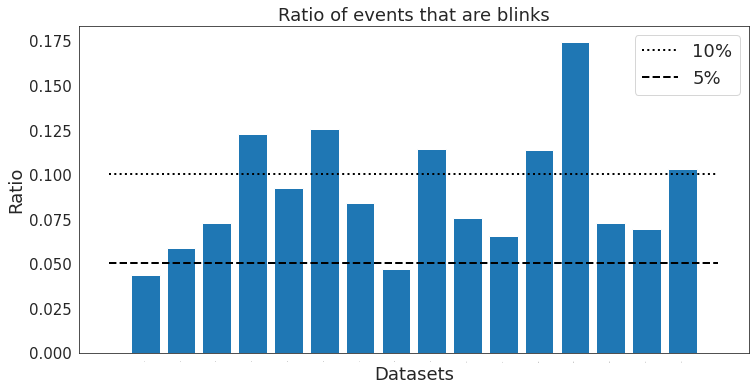

In [22]:
analyze_datasets(ratio_blinks_num, title='Ratio of events that are blinks')

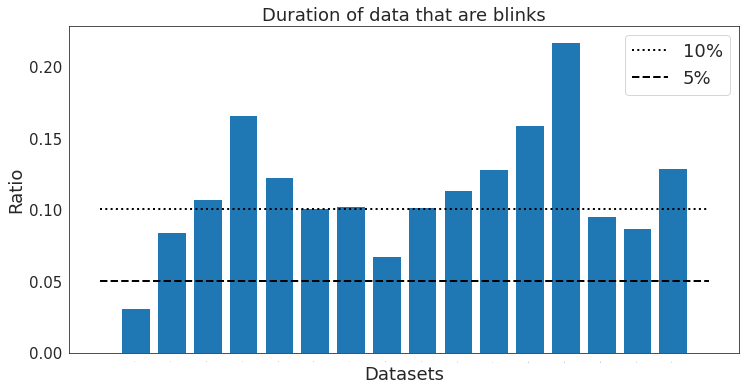

In [23]:
analyze_datasets(ratio_blinks_dur, title='Duration of data that are blinks')

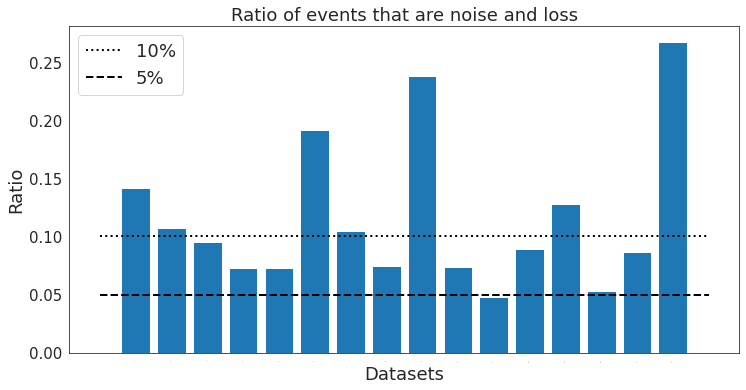

In [24]:
analyze_datasets(ratio_noise_loss_num, title='Ratio of events that are noise and loss')

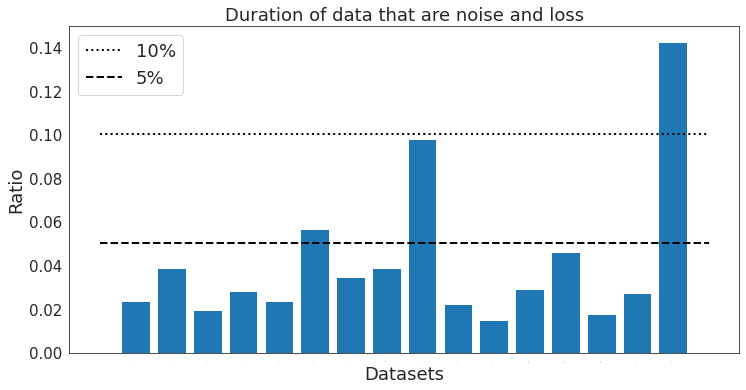

In [25]:
analyze_datasets(ratio_noise_loss_dur, title='Duration of data that are noise and loss')

## NN test performance and correlations


In [28]:
nn_ = nn.copy()

In [29]:
noise_num = pd.DataFrame(ratio_noise_loss_num,index=['noise_num']).T
noise_dur = pd.DataFrame(ratio_noise_loss_dur,index=['noise_dur']).T
blink_num = pd.DataFrame(ratio_blinks_num,index=['blink_num']).T
blink_dur = pd.DataFrame(ratio_blinks_dur,index=['blink_dur']).T
nn = pd.concat([nn_, noise_num, noise_dur, blink_num, blink_dur], axis=1).dropna()

In [30]:
# ensure frequencies and durations are correlated in noise and blinks
r, p = pearsonr(nn.noise_num, nn.noise_dur)
print(f'correlation between noise num and noise/loss dur:    r = {r},  p = {p}')
r, p = pearsonr(nn.blink_num, nn.blink_dur)
print(f'correlation between blink num and blink dur:         r = {r},  p = {p}')

correlation between noise num and noise/loss dur:    r = 0.9145191905469369,  p = 1.8215959266322363e-06
correlation between blink num and blink dur:         r = 0.8354547150483734,  p = 0.00010545442848689845


In [31]:
r, p = pearsonr(nn.test_acc, nn.noise_num)
print(f'correlation between test acc and noise/loss num:    r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.blink_num)
print(f'correlation between test acc and blinks:            r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.noise_dur)
print(f'correlation between test acc and noise/loss dur:    r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.blink_dur)
print(f'correlation between test acc and blink dur:         r = {r},  p = {p}')

correlation between test acc and noise/loss num:    r = 0.03011964476079334,  p = 0.9151413895100777
correlation between test acc and blinks:            r = -0.27007238147590673,  p = 0.3303072093027534
correlation between test acc and noise/loss dur:    r = 0.28997692743718095,  p = 0.2944605979329701
correlation between test acc and blink dur:         r = -0.1735454128851116,  p = 0.5362126305492055


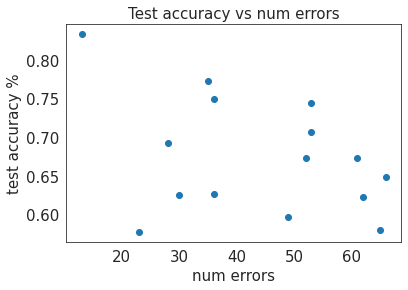

In [32]:
# scatter of test acc by num errors
plt.figure()
plt.scatter(nn.motor_error, nn.test_acc)
plt.xlabel('num errors',fontsize=15)
plt.ylabel('test accuracy %',fontsize=15)
plt.title('Test accuracy vs num errors',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

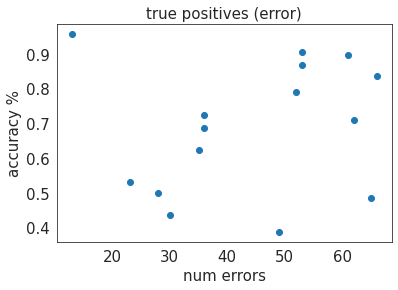

In [33]:
# scatter of test acc by num errors
plt.figure()
plt.scatter(nn.motor_error, nn.error_true)
plt.xlabel('num errors',fontsize=15)
plt.ylabel('accuracy %',fontsize=15)
plt.title('true positives (error)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

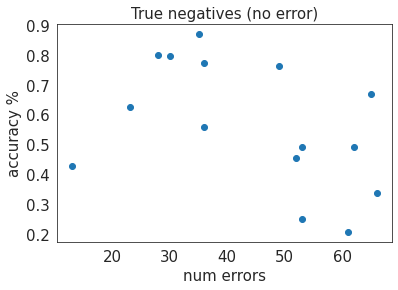

In [34]:
# scatter of test acc by num errors
plt.figure()
plt.scatter(nn.motor_error, nn.no_error_true)
plt.xlabel('num errors',fontsize=15)
plt.ylabel('accuracy %',fontsize=15)
plt.title('True negatives (no error)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

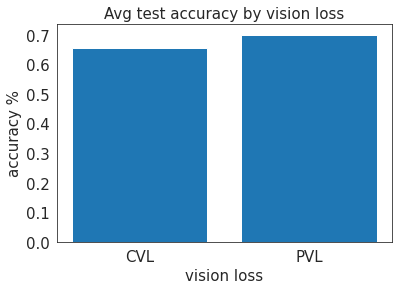

In [35]:
y = nn.groupby('VL').mean()

plt.figure()
plt.bar(y.index, y.test_acc)
plt.xlabel('vision loss',fontsize=15)
plt.ylabel('accuracy %',fontsize=15)
plt.title('Avg test accuracy by vision loss',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

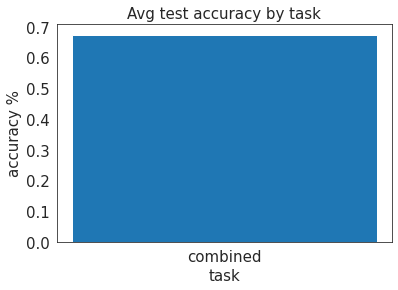

In [36]:
y = nn.groupby('task').mean()

plt.figure()
plt.bar(y.index, y.test_acc)
plt.xlabel('task',fontsize=15)
plt.ylabel('accuracy %',fontsize=15)
plt.title('Avg test accuracy by task',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [37]:
r, p = pearsonr(nn.test_acc, nn.error_true)
print(f'correlation between test acc and true positive (error):    r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.no_error_true)
print(f'correlation between test acc and true negtaive (no error): r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.motor_error)
print(f'correlation between test acc and number motor errors:      r = {r},  p = {p}')

correlation between test acc and true positive (error):    r = 0.6164612014379741,  p = 0.014385882703742154
correlation between test acc and true negtaive (no error): r = -0.1240406480218775,  p = 0.6596200565827325
correlation between test acc and number motor errors:      r = -0.37740371290538227,  p = 0.1655022241216336


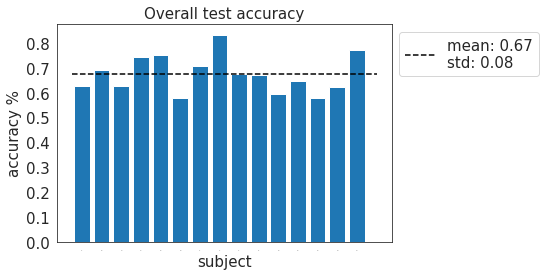

In [38]:
plt.figure()
plt.bar(nn.index, nn.test_acc)
plt.xlabel('subject',fontsize=15)
plt.ylabel('accuracy %',fontsize=15)
plt.title('Overall test accuracy',fontsize=15)
plt.xticks(fontsize=0)
plt.yticks(fontsize=15)
text = f'mean: {np.round(nn.test_acc.mean(),2)}\nstd: {np.round(nn.test_acc.std(),2)}'
plt.hlines(nn.test_acc.mean(),-0.5,15,linestyle='--',color='black',label=text)
plt.legend(bbox_to_anchor=(1,1),loc='upper left', fontsize=15)
plt.show()

In [39]:
nn.groupby(['VL','task']).count()

,,avg_tot_dur,train_loss,train_acc,test_acc,error_true,no_error_true,error_true_accs,no_error_true_accs,motor_error,noise_num,noise_dur,blink_num,blink_dur
VL,task,,,,,,,,,,,,,
CVL,combined,9,9,9,9,9,9,9,9,9,9,9,9,9
PVL,combined,6,6,6,6,6,6,6,6,6,6,6,6,6


In [40]:
r, p = pearsonr(nn.test_acc, nn.avg_tot_dur)
print(f'correlation between test acc and average window size (sec):    r = {r},  p = {p}')
r, p = pearsonr(nn.test_acc, nn.train_acc)
print(f'correlation between test acc and training acc:                 r = {r},  p = {p}')


correlation between test acc and average window size (sec):    r = 0.06682907134900298,  p = 0.8129384768333574
correlation between test acc and training acc:                 r = 0.7249465601570745,  p = 0.002229528622059869


In [41]:
print('Average NN performance:')
print(f'Overall test accuracy:    {np.round(nn.test_acc.mean()*100,2)}%')
print(f'True positive (error):    {np.round(nn.error_true.mean()*100,2)}% with accuracy {np.round(nn.error_true_accs.mean()*100,2)}% ')
print(f'True negative (no error): {np.round(nn.no_error_true.mean()*100,2)}% with accuracy {np.round(nn.no_error_true_accs.mean()*100,2)}% ')


Average NN performance:
Overall test accuracy:    67.46%
True positive (error):    68.89% with accuracy 95.32% 
True negative (no error): 56.73% with accuracy 95.01% 


In [ ]:
# confusion matrix of averages
# plot_df = pd.DataFrame({'Target':targs, 'Prediction':preds})
# confusion_matrix = pd.crosstab(plot_df['Prediction'], plot_df['Target'], rownames=['Prediction'], colnames=['Target'])
# confusion_matrix = confusion_matrix.apply(lambda x: x/x.sum(), axis=0)

# plt.figure()
# sns.heatmap(confusion_matrix, annot=True)
# plt.savefig('/home/s202576/thesis_spring2022/NN/models/test/{subID}'.format(subID=SUBJECT))
# plt.show()